Exploratory data analysis of the Hotel Booking Demand dataset
================
- contributors: Debananda Sarkar, Chen Zhao, Jared Splinter, Peter Yang
- Created on: 2020-11-21


# Summary of the data set

The data set used in this project comes from the Hotel Booking demand datasets from [Antonio, Almeida and Nunes, 2019](https://www.sciencedirect.com/science/article/pii/S2352340918315191#ack0005) and the data can be found from the GitHub Repository [here](https://github.com/rfordatascience/tidytuesday/tree/master/data/2020/2020-02-11). The dataset contains real world data obtained from two hotels: one resort hotel and one city hotel. Each row represents an individual hotel booking due to arrive between July 1st, 2015 and August 31st, 2017. There are 119390 observations in the data set, and 31 features. The following table shows the counts of observations for each hotel. 

| Resort Hotel | City Hotel |
| -----------: | ---------: |
|        40060 |      79330 |

                                                                        Table 1: Counts of observation for each hotel. 

# Import Packages and Load Data

In [1]:
# common packages
import numpy as np
import pandas as pd

# ML packages
from sklearn.model_selection import train_test_split

# Visualization packages
import altair as alt
# Save a vega-lite spec and a PNG blob for each plot in the notebook
alt.renderers.enable('mimetype')
# Handle large data sets without embedding them in the notebook
alt.data_transformers.enable('data_server')

# set seed
seed = 2020

# Load data:
hotels_df = pd.read_csv("../data/raw/hotels_dataset.csv")

In [2]:
# Split data:
# 80% of observations are in the training and 20% of observations are in the test set
train_df, test_df = train_test_split(hotels_df, test_size=0.2, random_state=seed)

# Split the features and targets:
X_train = train_df.drop(["is_canceled"], axis=1)
y_train = train_df["is_canceled"]
X_test = test_df.drop(["is_canceled"], axis=1)
y_test = test_df["is_canceled"]

## Splitting the data set into training and test data sets

- 80% of observations are in the training and 20% of observations are in the test set

| Data partition | Is Canceled | Is Not Canceled |
| :------------- | -----------: | ---------: |
| Training       |       35407 |     60105 |
| Test           |         8817 |      15061 |

                                                            Table 2: Counts of observation for each hotel for each data partition

There is a class imbalance, We would like to predict the cancellation as accurately as possible, so that the hotel does not get a unwanted surprise. Hence, we would like to maximize recall.However, in the process of maximizing recall we might over predict cancellation. That will be an adverse scenario as the management may get into panic and start introducing promotions which might take a toll of hotel revenue. Hence, we would like to keep the precision high as well. As we are interested in keeping both precision and recall high, **f1-score** will be a good evaluation metric here.

# Viewing the Train data set

In [3]:
train_df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
74159,City Hotel,1,349,2015,October,40,1,0,2,2,...,Non Refund,1.0,NaN,0,Contract,62.00,0,0,Canceled,2015-01-01
59282,City Hotel,1,254,2016,October,44,25,0,5,2,...,No Deposit,9.0,NaN,0,Transient,90.95,0,0,Canceled,2016-02-17
56463,City Hotel,1,174,2016,September,37,7,0,1,2,...,No Deposit,9.0,NaN,0,Transient,126.90,0,2,Canceled,2016-08-24
94823,City Hotel,0,169,2016,August,32,5,2,4,2,...,No Deposit,9.0,NaN,0,Transient,99.45,0,1,Check-Out,2016-08-11
247,Resort Hotel,1,69,2015,July,28,9,2,6,2,...,No Deposit,240.0,NaN,0,Transient,118.13,0,2,Canceled,2015-05-13


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95512 entries, 74159 to 41824
Data columns (total 32 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           95512 non-null  object 
 1   is_canceled                     95512 non-null  int64  
 2   lead_time                       95512 non-null  int64  
 3   arrival_date_year               95512 non-null  int64  
 4   arrival_date_month              95512 non-null  object 
 5   arrival_date_week_number        95512 non-null  int64  
 6   arrival_date_day_of_month       95512 non-null  int64  
 7   stays_in_weekend_nights         95512 non-null  int64  
 8   stays_in_week_nights            95512 non-null  int64  
 9   adults                          95512 non-null  int64  
 10  children                        95508 non-null  float64
 11  babies                          95512 non-null  int64  
 12  meal                        

In [5]:
# Check Null values
null_df = train_df.isna().sum().reset_index(name="count_of_nulls").query("count_of_nulls != 0")
null_df["perc"] = np.round(null_df["count_of_nulls"] / train_df.shape[0] * 100, 2)
null_df

,index,count_of_nulls,perc
10,children,4,0.00
13,country,383,0.40
23,agent,13101,13.72
24,company,90071,94.30


### Train data set observations

Our train data set has a number of numeric and categorical features to be explored as well as many that may not be useful for prediction. There are also a few features that have a large number of missing values. The most of which is the feature "company" which can likely be omitted from the analysis as ~94% of the observations have null values. Next steps will require delving more into the features to see if they serve any purpose for training or if they should be omited.

# Exploratory Analysis Visualizations 

## Feature Correlations

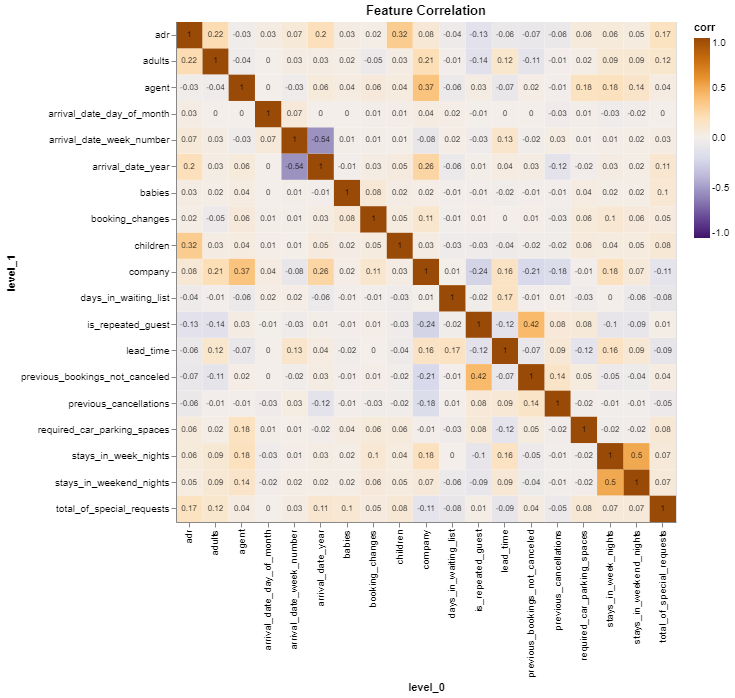

In [6]:
corr_df = train_df.corr().stack().reset_index(name="corr")
corr_df["round_corr"] = np.round(corr_df["corr"], 2)
corr_plot = (
    alt.Chart(corr_df.query("level_0 != 'is_canceled' & level_1 != 'is_canceled'"), title="Feature Correlation")
    .mark_rect()
    .encode(
        x="level_0",
        y="level_1",
        tooltip="corr",
        color=alt.Color("corr", scale=alt.Scale(domain=(-1, 1), scheme="purpleorange"))
    )
    .properties(width=500, height=500)
)
corr_text = (
    alt.Chart(corr_df.query("level_0 != 'is_canceled' & level_1 != 'is_canceled'"))
    .mark_text(size=8)
    .encode(
        x="level_0",
        y="level_1",
        text="round_corr",
    )
    .properties(width=500, height=500)
)
corr_plot + corr_text

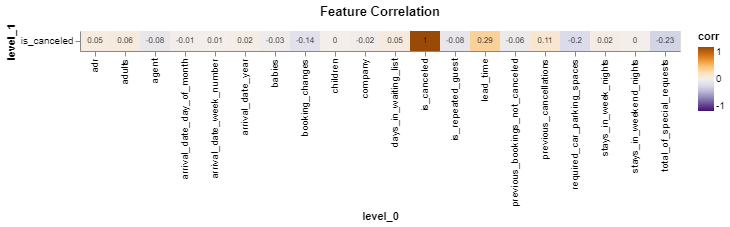

In [7]:
corr_plot = (
    alt.Chart(corr_df[corr_df.level_1 == "is_canceled"], title="Feature Correlation")
    .mark_rect()
    .encode(
        x="level_0",
        y="level_1",
        tooltip="corr",
        color=alt.Color("corr", scale=alt.Scale(domain=(-1, 1), scheme="purpleorange"))
    )
    .properties(width=600)
)
corr_plot

corr_text = (
    alt.Chart(corr_df[corr_df.level_1 == "is_canceled"])
    .mark_text(size=8)
    .encode(
        x="level_0",
        y="level_1",
        text="round_corr",
    )
    .properties(width=600)
)
corr_plot + corr_text

### Correlation Observations:

There is a moderate correlation between `arrival_date_week_number` and `arrival_date_year` as well as `stay_in_week_nights` and `stay_in_weekend_nights`. These may be expected values however, we need to explore the relations further in regards to training our model. There is also some correlation between `lead_time` and `total_of_special_requests` with the target. Further analysis will reveal if these are useful features for predicting the target.

## Feature Distributions

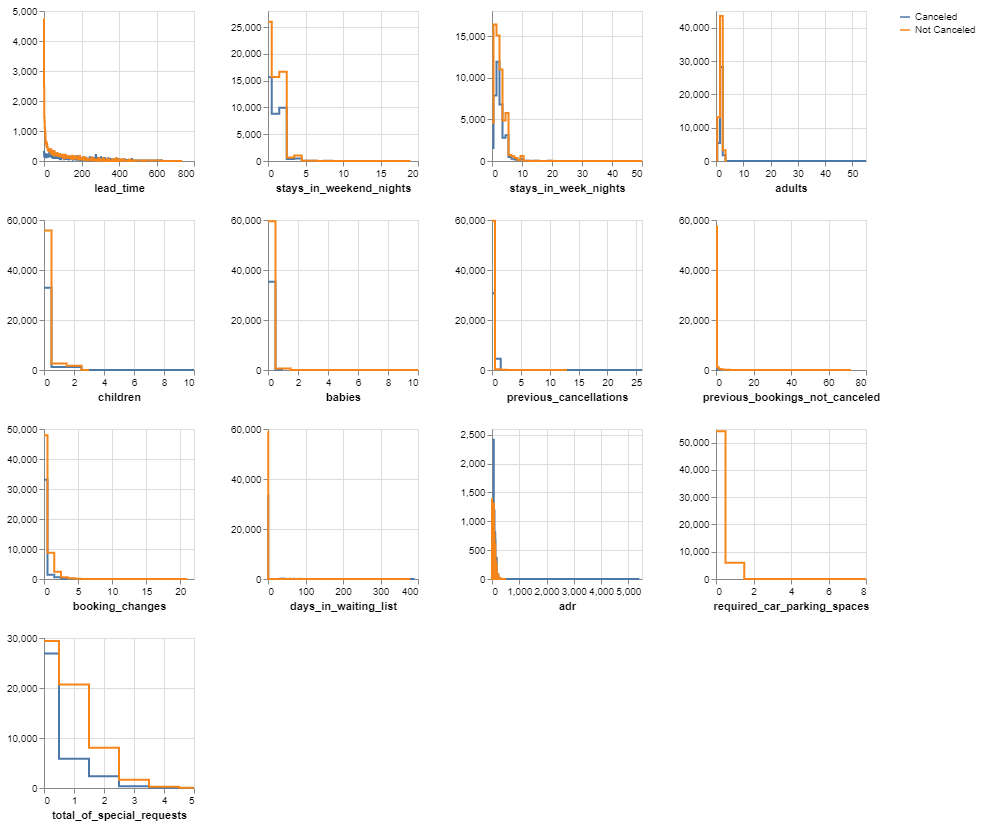

In [8]:
numeric_features = [
    "lead_time",
    "stays_in_weekend_nights",
    "stays_in_week_nights",
    "adults",
    "children",
    "babies",
    "previous_cancellations",
    "previous_bookings_not_canceled",
    "booking_changes",
    "days_in_waiting_list",
    "adr",
    "required_car_parking_spaces",
    "total_of_special_requests"
]

train_df = train_df.copy()
train_df["is_canceled_cat"] = train_df["is_canceled"].apply(lambda x: "Canceled" if x == 1 else "Not Canceled")#.copy()
(alt.Chart(train_df)
 .mark_line(interpolate='step').encode(
     alt.X(alt.repeat(), type='quantitative'),
     alt.Y('count()', title = ""),
     alt.Color('is_canceled_cat', title = ""))) .properties(width=150, height=150).repeat(numeric_features,columns = 4)

### Distribution Observations:

For our numeric feature distributions we find many of the numeric features are right skewed as they are dominated by `0` values. This may mean many of these numeric features may not be good predictors of the target and score low coefficient weights. A few numeric features that look promising for prediciton are `total_of_special_requests`, `required_car_parking_spaces`, `stay_in_week_nights` and `stay_in_weekend_nights` as they have wider distributions.

## Feature Examination

In [9]:
top_20_countries = (
    X_train.groupby("country")
    .size()
    .reset_index(name="counts")
    .sort_values(by="counts", ascending=False)[:20]
)

countries = alt.Chart(top_20_countries, title="Top 20 home country of guests").mark_bar().encode(
    alt.X("counts", title="Guests numbers"),
    alt.Y("country", sort="-x", title="Country"),
    alt.Tooltip("country"),
)#.configure_axis(labelFontSize=10, titleFontSize=12).configure_title(fontSize=15)

In [10]:
# Counting adults and children as paying guests only, not babies.

X_train["adr_ac"] = X_train["adr"] / (X_train["adults"] + X_train["children"])
room_price = X_train[["hotel", "reserved_room_type", "adr_ac"]].sort_values(
    "reserved_room_type"
)

room_price = alt.Chart(room_price).mark_boxplot(extent="min-max", clip=True).encode(
    alt.X("adr_ac", title="Price [EUR]", scale=alt.Scale(domain=(0, 120))),
    alt.Y("hotel", title="Hotel"),
    color="hotel",
).facet(
    "reserved_room_type",
    columns=2,
    title="Price per night and person for different room types",
)#.configure_axis(
 #   labelFontSize=10, titleFontSize=12
#).configure_title(
 #   fontSize=15
#)

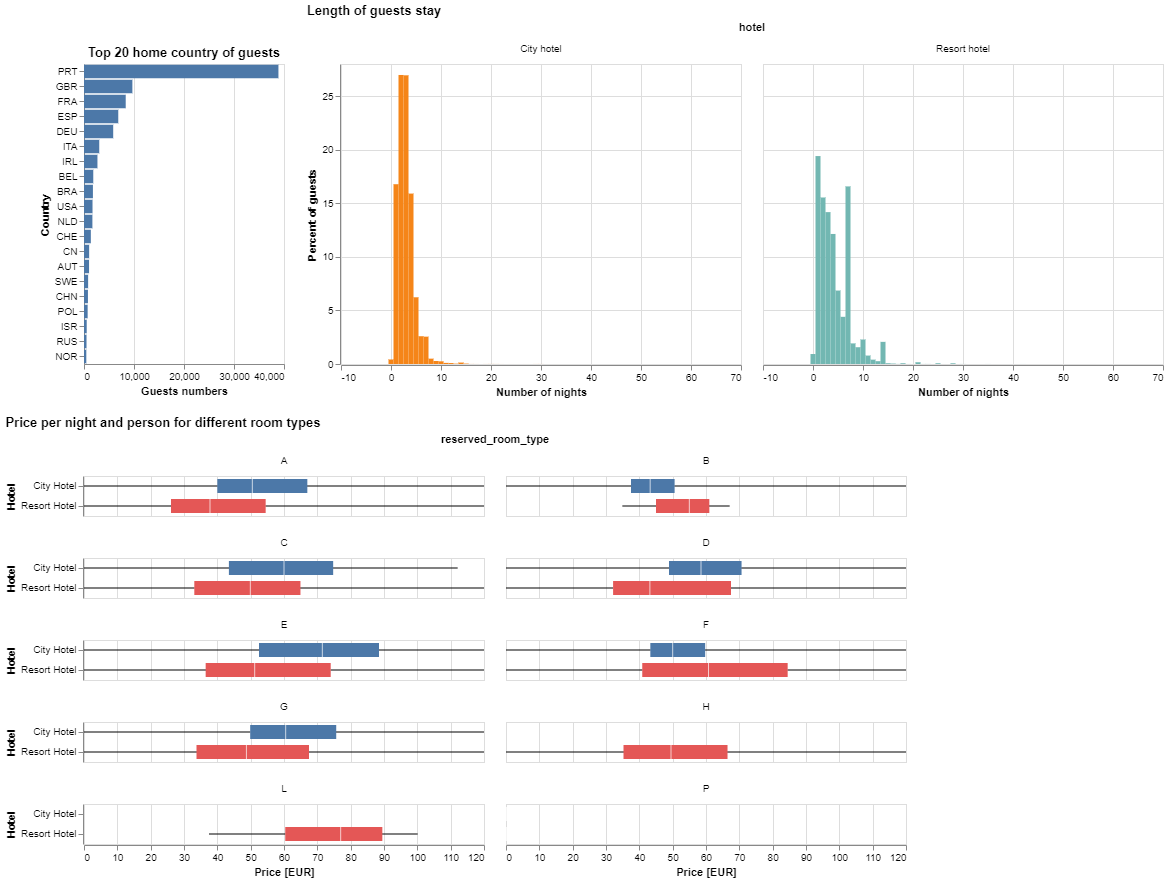

In [11]:
# Seperate Resort adn City Hotel:
resort_train = X_train.loc[(X_train["hotel"] == "Resort Hotel")].copy()
city_train = X_train.loc[(X_train["hotel"] == "City Hotel")].copy()

resort_train["total_nights"] = (
    resort_train["stays_in_weekend_nights"] + resort_train["stays_in_week_nights"]
)
city_train["total_nights"] = (
    city_train["stays_in_weekend_nights"] + city_train["stays_in_week_nights"]
)

num_nights_resort = list(resort_train["total_nights"].value_counts().index)
num_bookings_resort = list(resort_train["total_nights"].value_counts())
rel_bookings_resort = (
    resort_train["total_nights"].value_counts() / sum(num_bookings_resort) * 100
)  # convert to percent

num_nights_city = list(city_train["total_nights"].value_counts().index)
num_bookings_city = list(city_train["total_nights"].value_counts())
rel_bookings_city = (
    city_train["total_nights"].value_counts() / sum(num_bookings_city) * 100
)  # convert to percent

resort_nights = pd.DataFrame(
    {
        "hotel": "Resort hotel",
        "num_nights": num_nights_resort,
        "rel_num_bookings": rel_bookings_resort,
    }
)

city_nights = pd.DataFrame(
    {
        "hotel": "City hotel",
        "num_nights": num_nights_city,
        "rel_num_bookings": rel_bookings_city,
    }
)

nights_data = pd.concat([resort_nights, city_nights], ignore_index=True)
nights_data

stay = alt.Chart(nights_data).mark_bar().encode(
    alt.X("num_nights", title="Number of nights"),
    alt.Y("rel_num_bookings", title="Percent of guests"),
    color=alt.Color("hotel", legend = None),
).facet("hotel", title="Length of guests stay")#.configure_axis(
   # labelFontSize=10, titleFontSize=12
##.configure_title(
 #   fontSize=15
#)

((countries.properties(height=300,width = 200) |stay) & room_price)

### Examination Observations

Looking in depth at a few features we find some interesting results. First, we notice most of our observations come from European countries, specifically most are from Portugal. It may be that model may perform better predicting on guests from non European countries. Or perhaps, the model will perform worse due to limitations from the data set coming from 2 hotels, most of the observations come because most of the guests are mainly European.

Second, looking at the number of nights stayed we find a difference between the hotels. For the city hotel, guests tend to stay for 1-4 nights. While for the resort hotel, the distribution is similar, but more guests stay up to 7 nights. This could be because there is a tendency for resort hotel guests to stay longer.

We can hypothesize that room price could be a good predictor for a cancellation. We find a difference in room prices between the resort and city hotels in the different room types. Perhaps the roomy type prices have a role in prediction. The limitations of this feature are that there is no currency information for price in the dataset, but we know most of guests are from European countries so it may be safe to assume that all prices all in EUR. Additionally, due to guest anonymity reasons, the rooms types are only given as letters, so we would not be able to tell which specific room types are good predictors.

# References

<div id="refs" class="references">

<div id="ref-Hotel2019">

Antonio, Nuno, Ana de Almeida, and Luis Nunes. 2019. "Hotel booking demand datasets." Data in brief 22: 41-49. <https://doi.org/10.1016/j.dib.2018.11.126>

</div>

</div>